

TOP 10 COUNTRIES WITH HIGHEST CONFIRMED CASES 

['US', 'India', 'Brazil', 'Russia', 'France', 'United Kingdom', 'Turkey', 'Italy', 'Spain', 'Argentina']


TOP 10 COUNTRIES WITH HIGHEST DEATHS 

['US', 'Brazil', 'India', 'Mexico', 'Italy', 'United Kingdom', 'France', 'Iran', 'Russia', 'Spain']


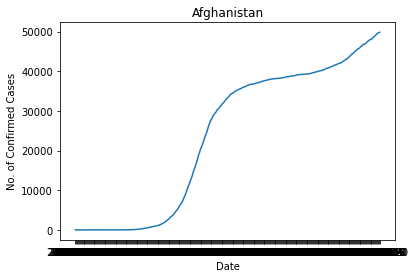

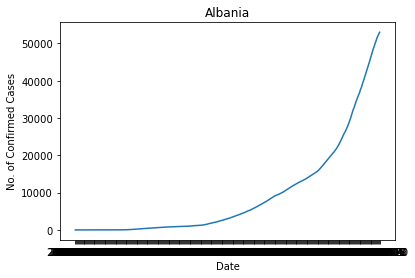

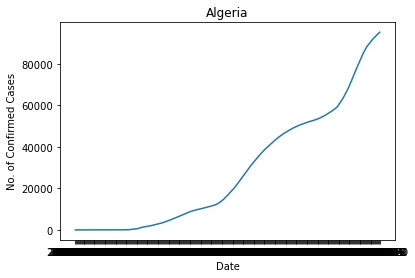

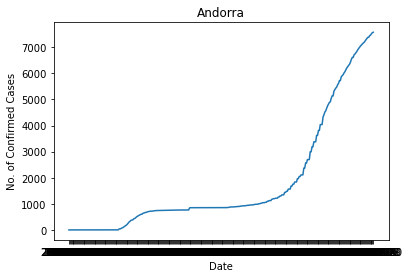

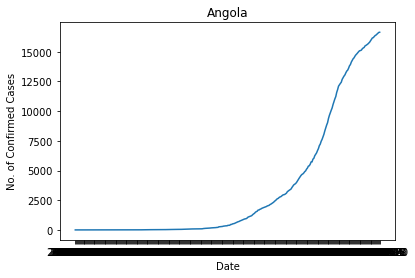

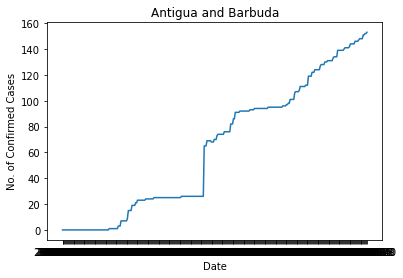

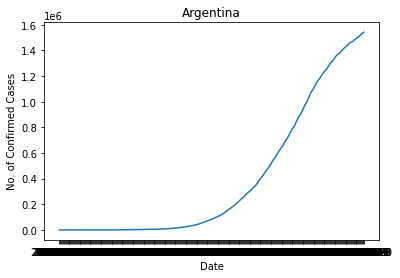

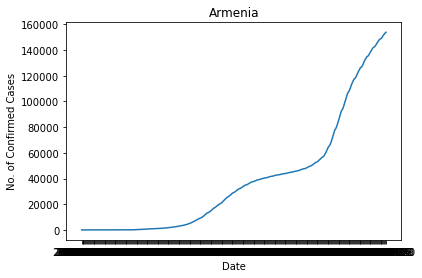

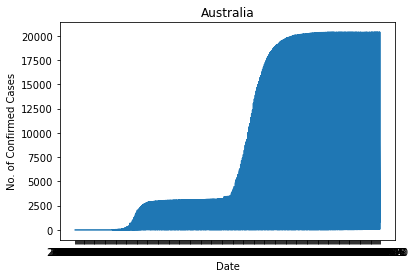

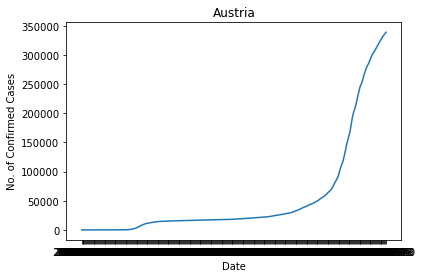

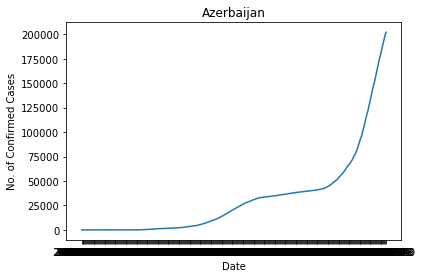

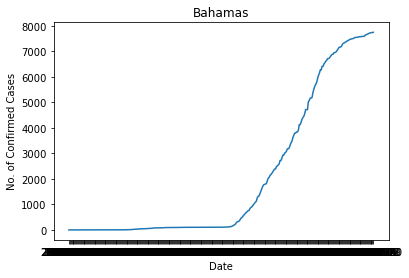

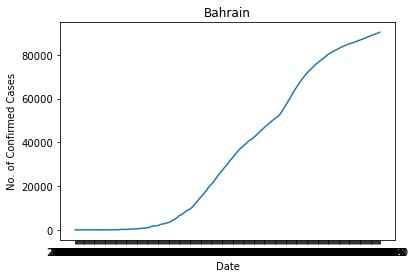

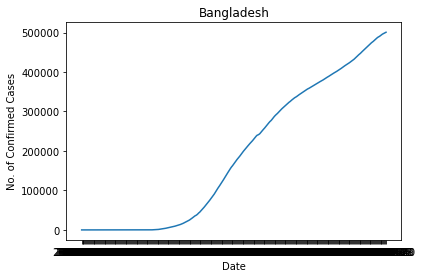

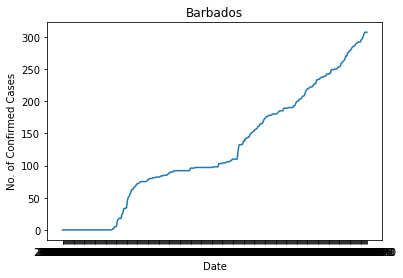

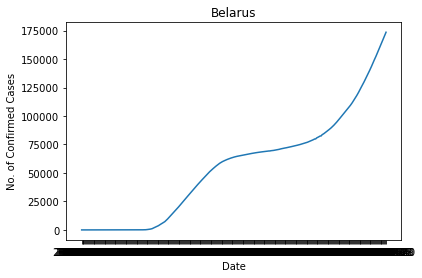

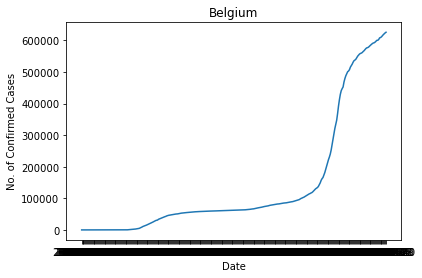

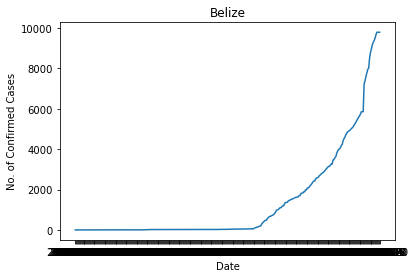

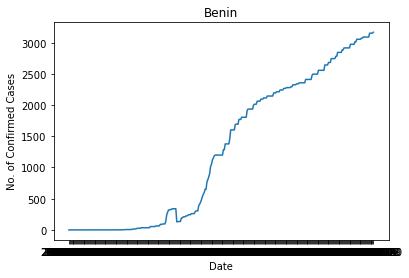

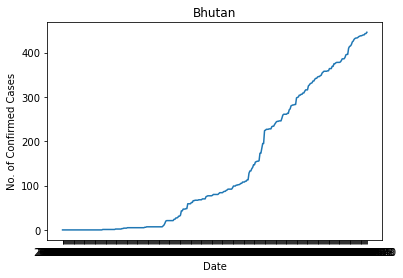

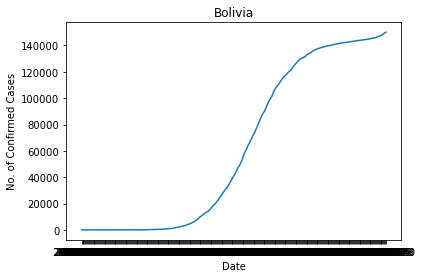

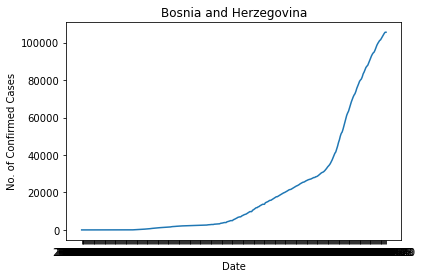

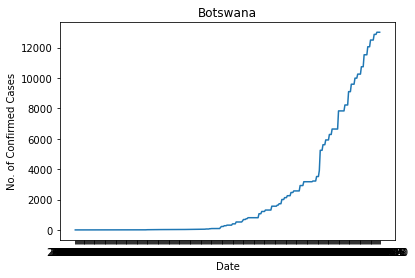

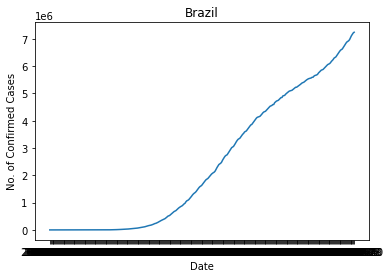

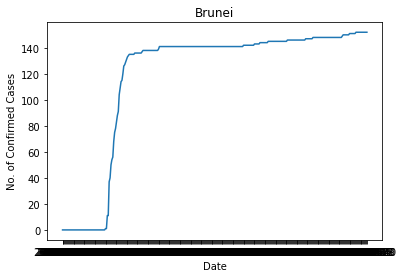

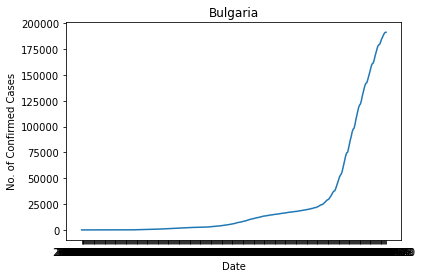

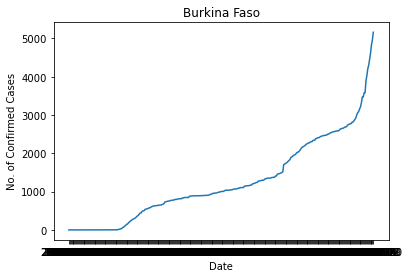

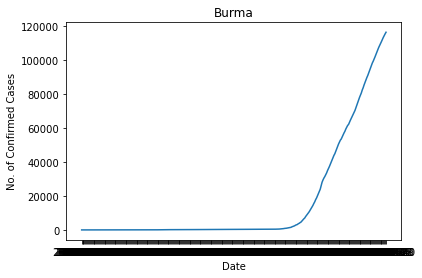

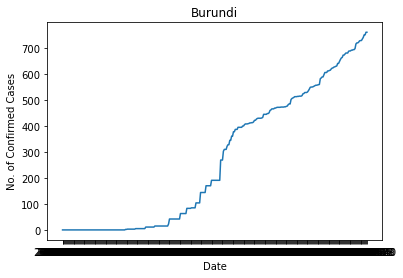

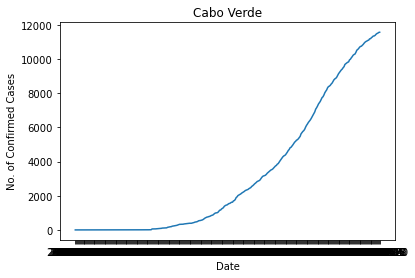

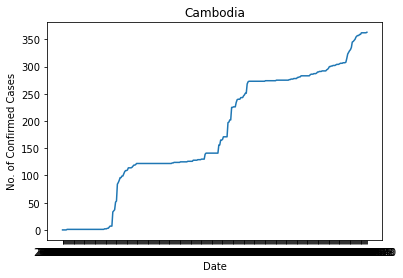

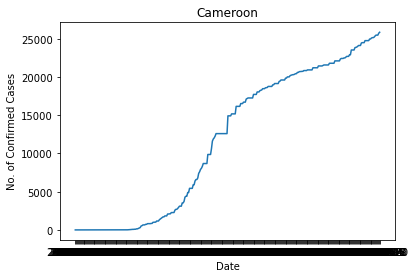

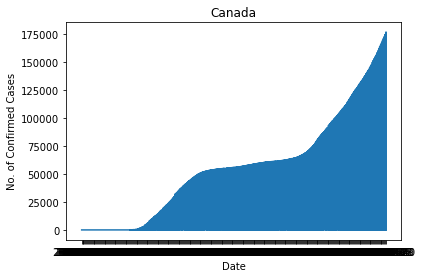

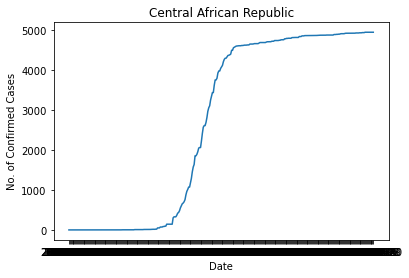

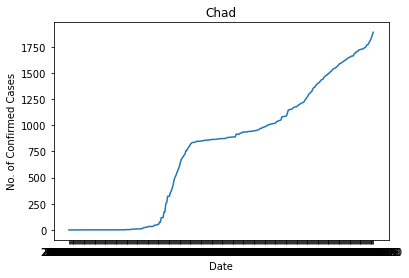

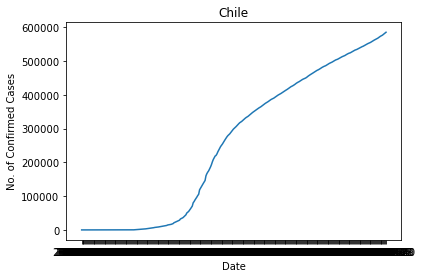

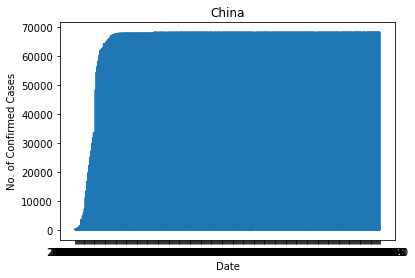

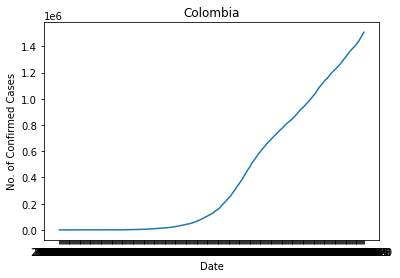

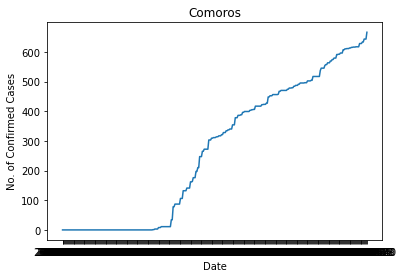

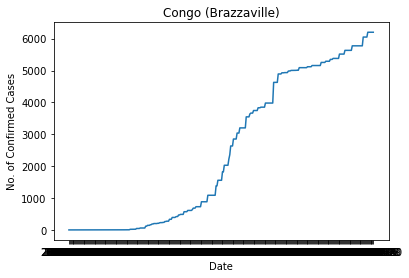

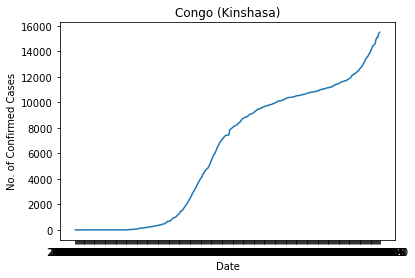

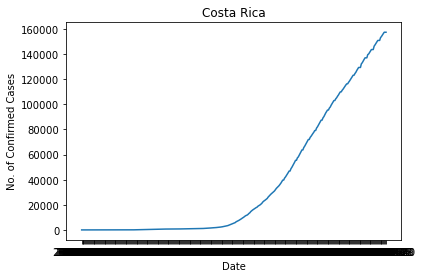

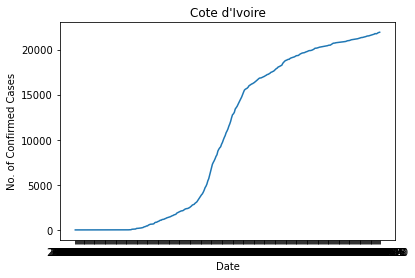

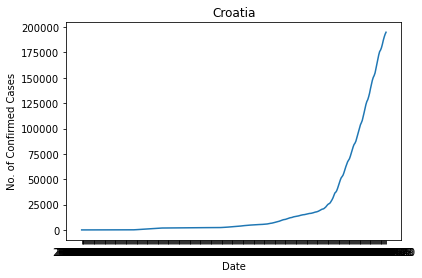

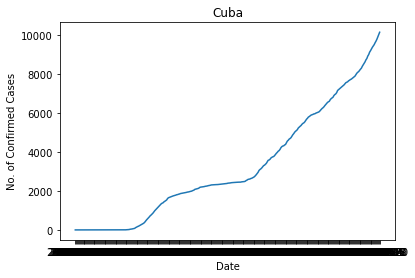

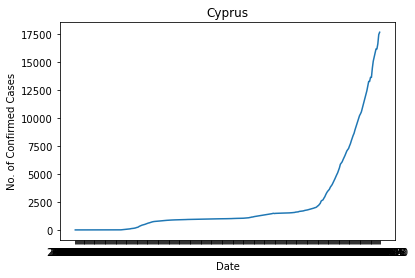

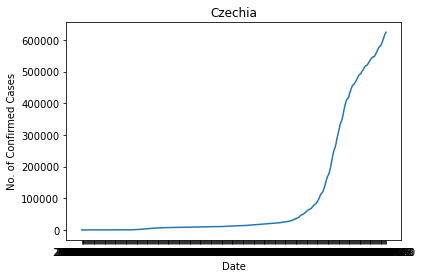

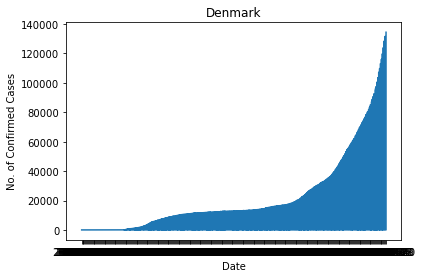

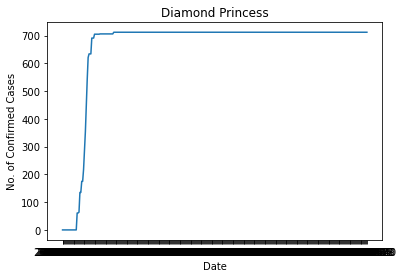

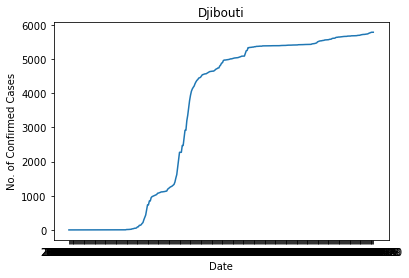

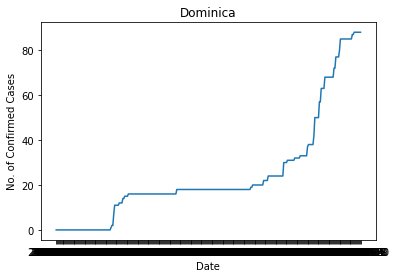

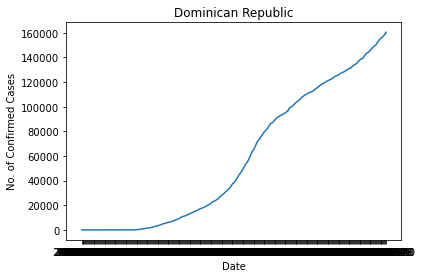

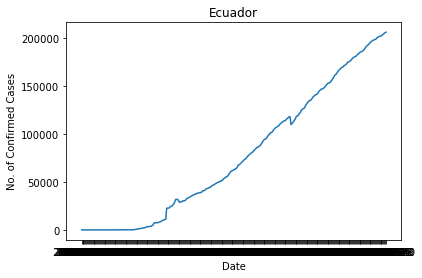

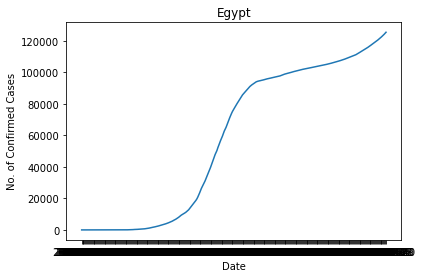

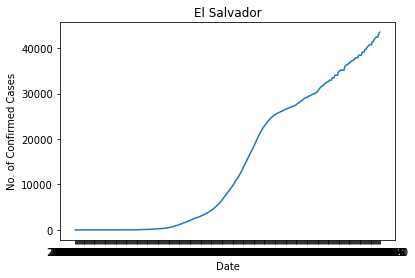

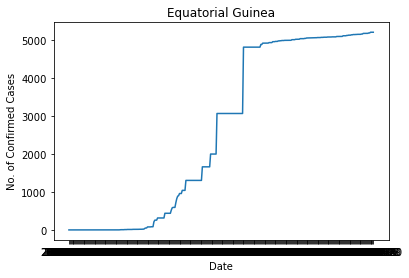

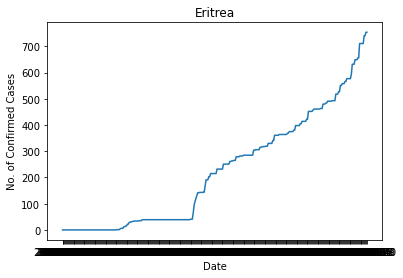

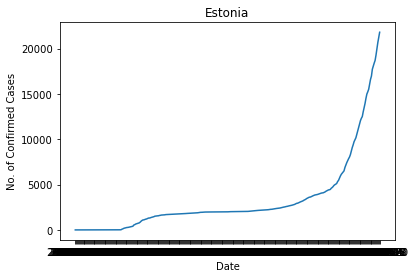

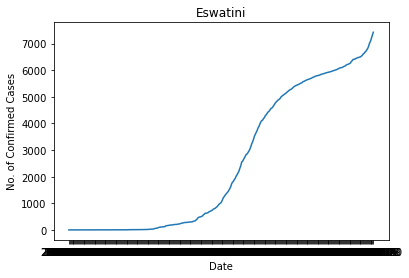

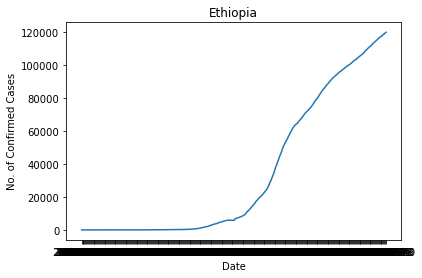

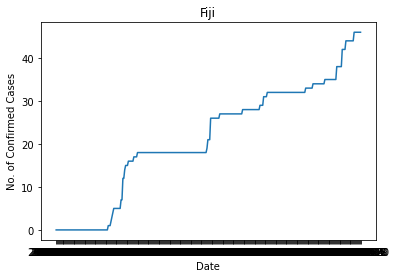

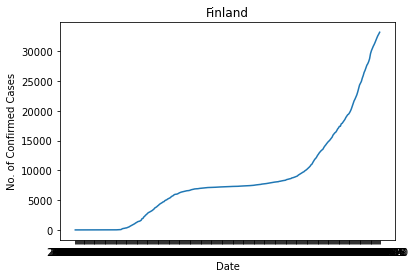

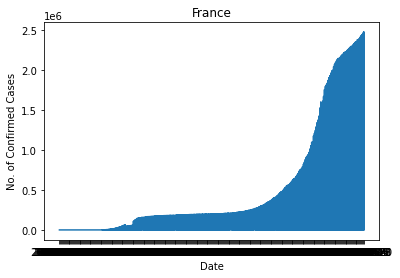

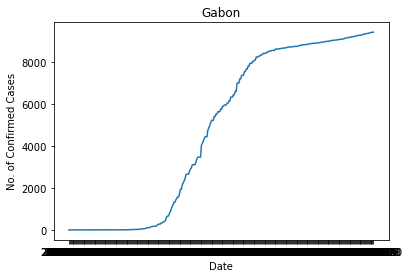

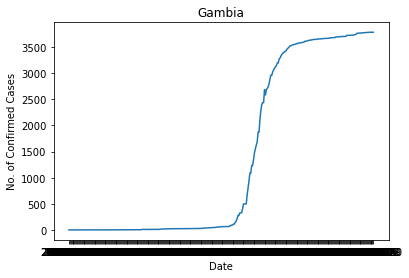

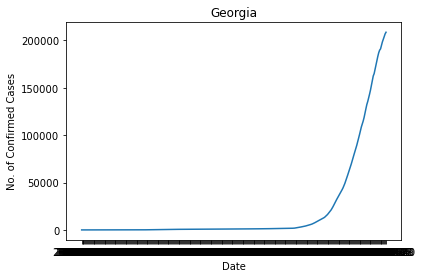

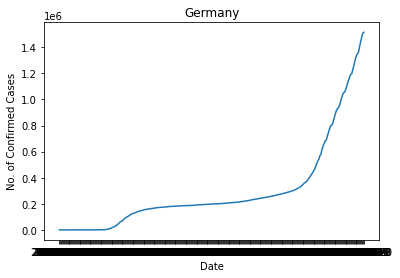

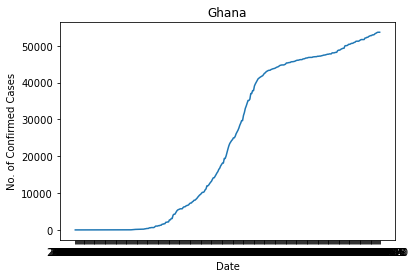

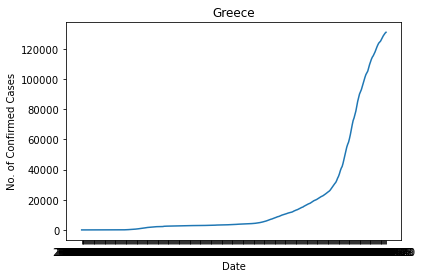

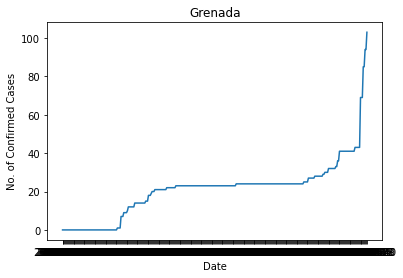

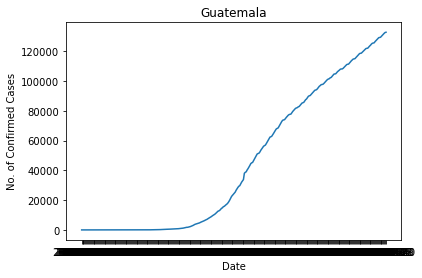

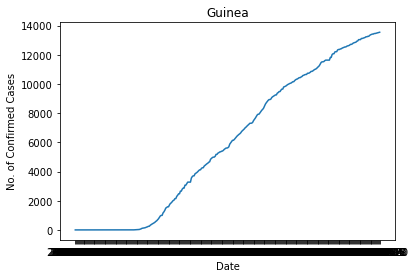

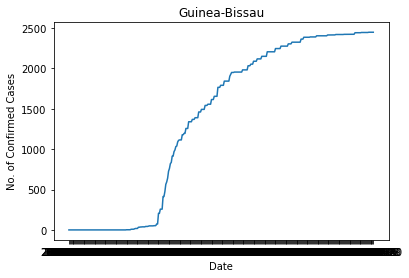

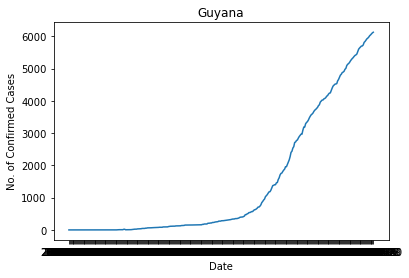

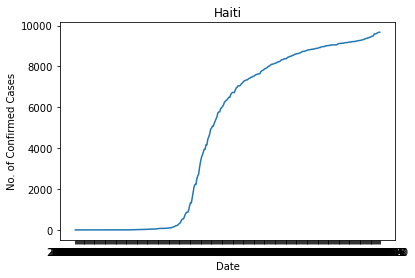

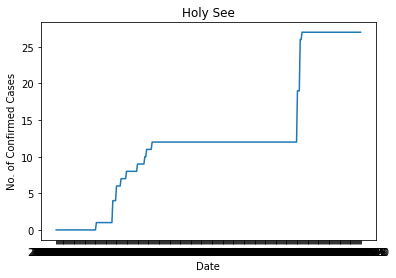

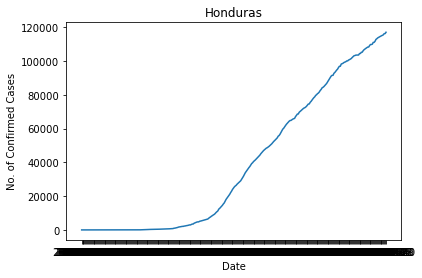

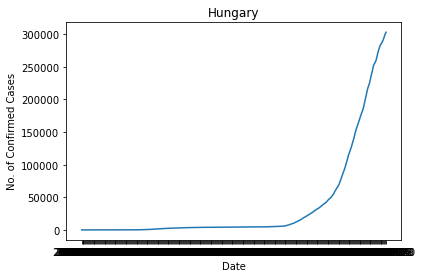

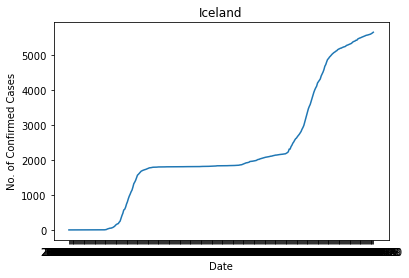

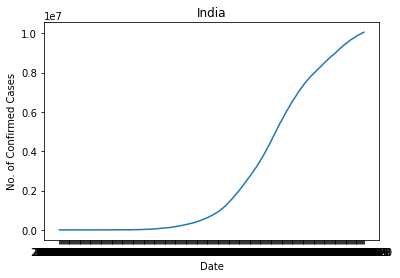

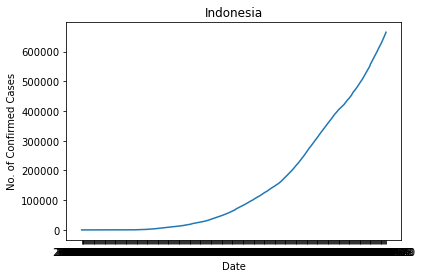

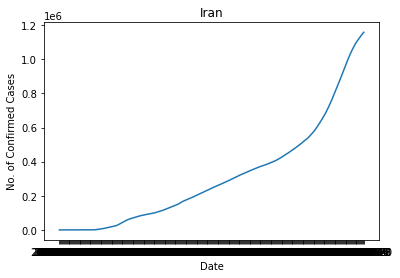

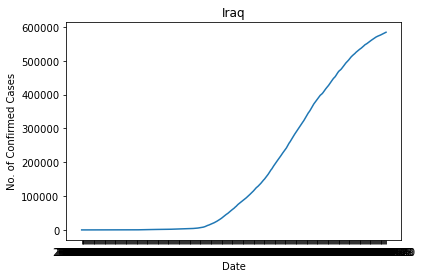

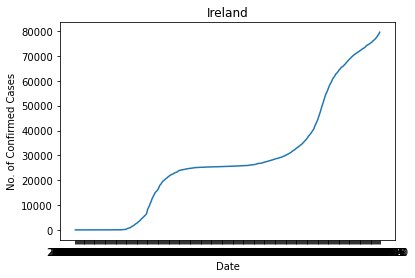

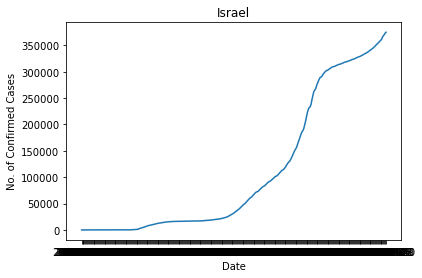

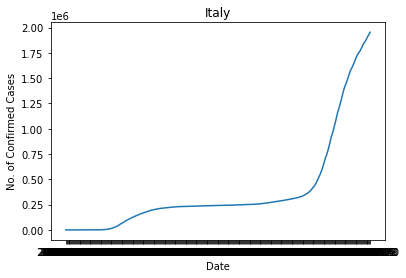

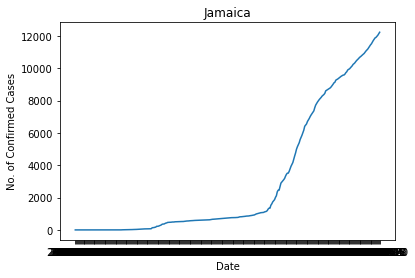

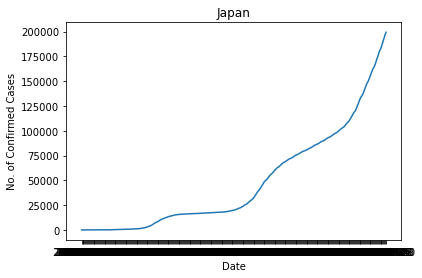

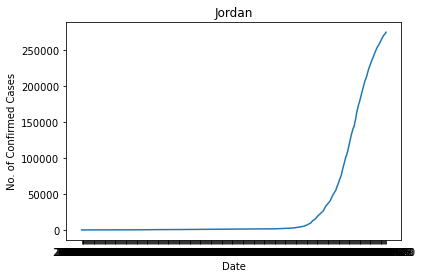

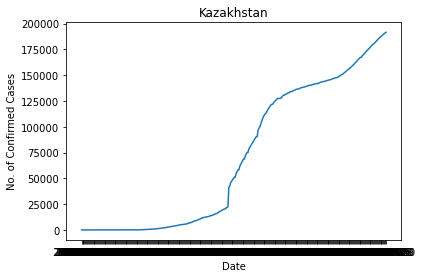

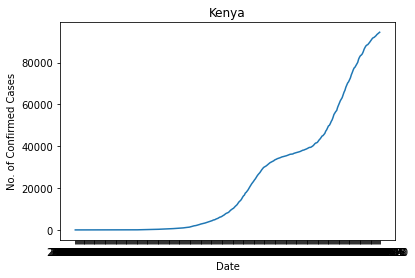

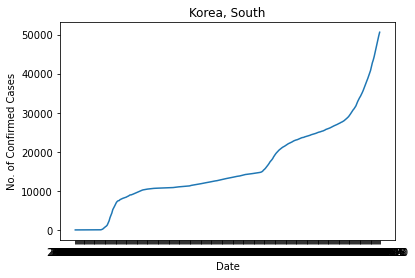

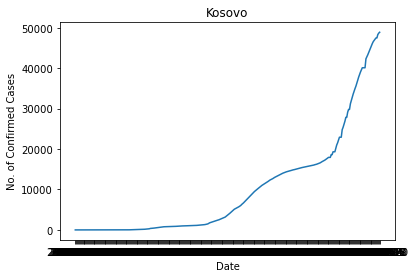

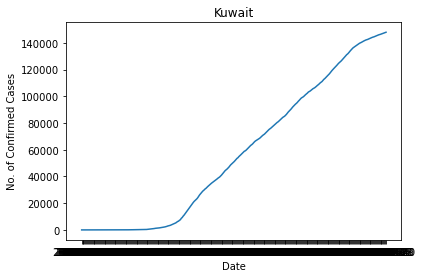

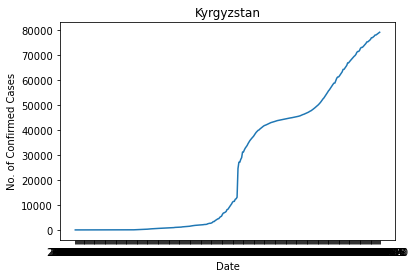

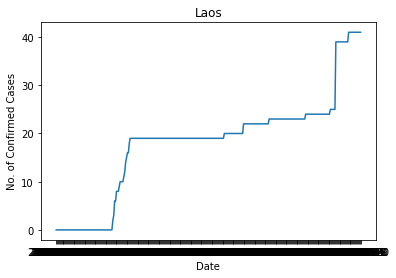

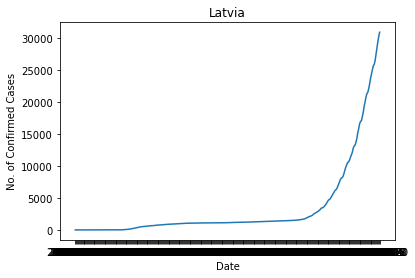

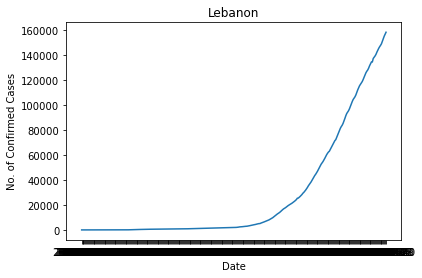

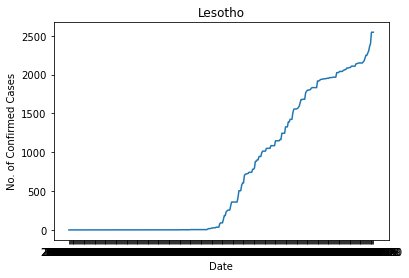

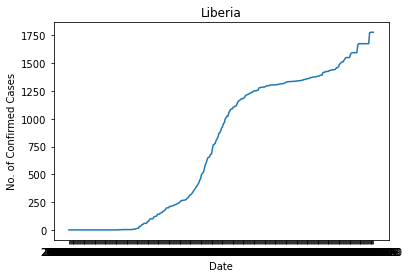

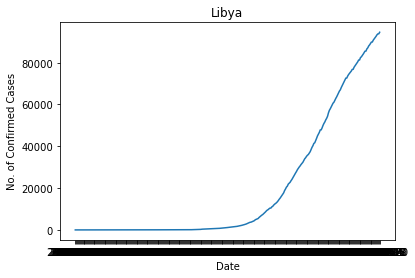

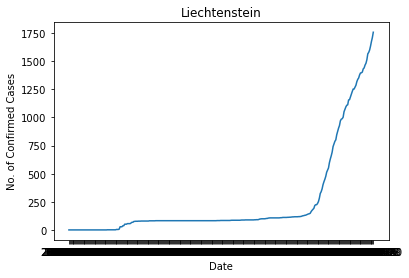

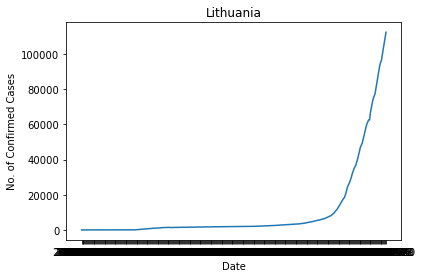

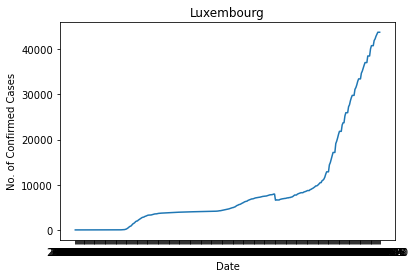

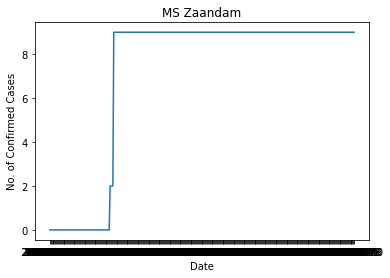

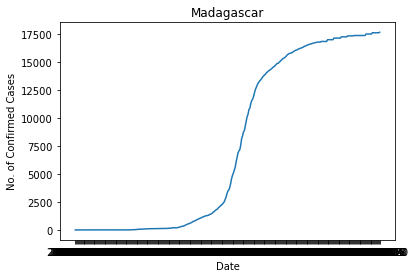

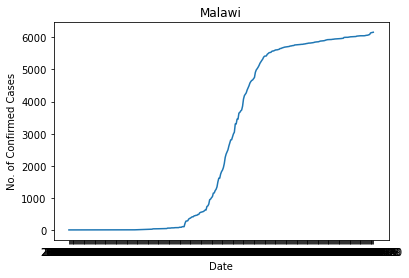

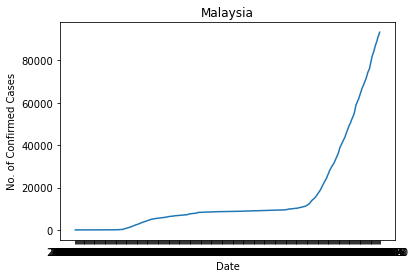

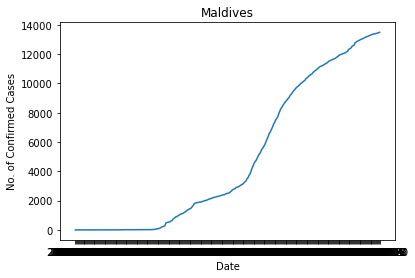

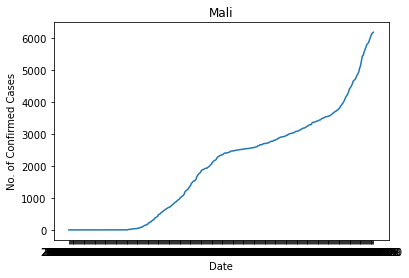

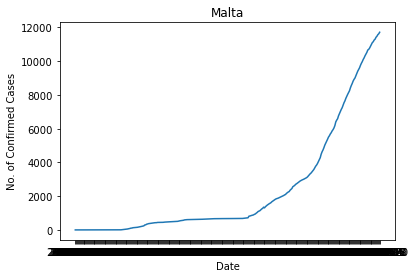

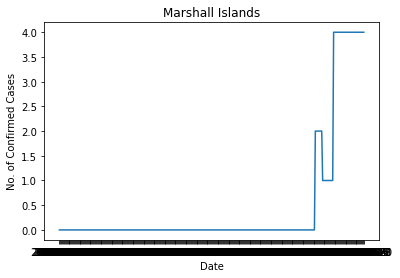

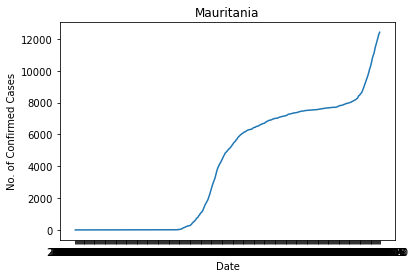

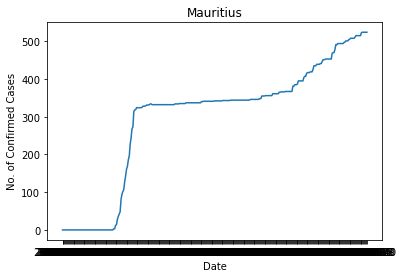

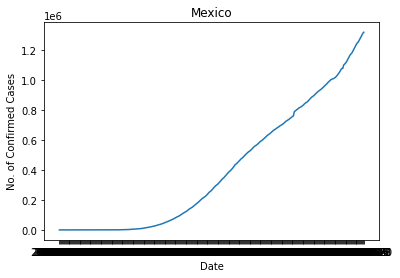

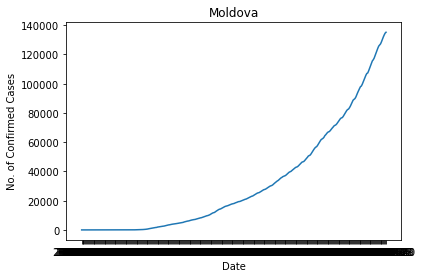

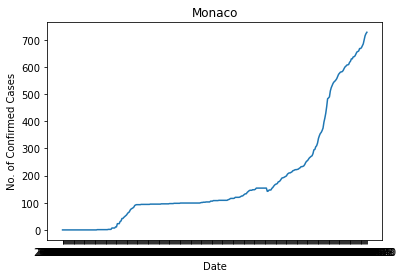

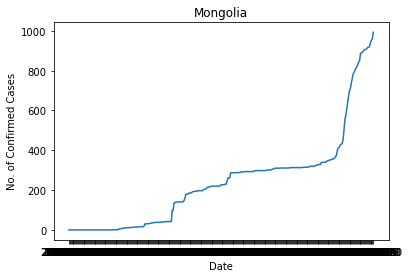

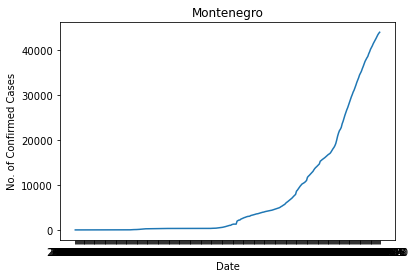

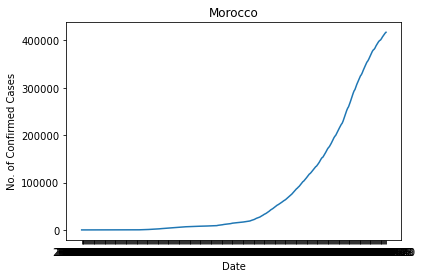

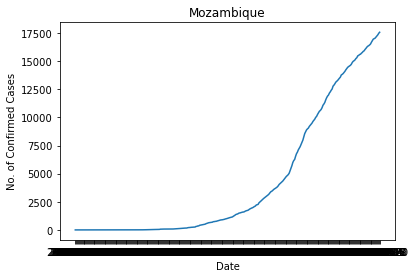

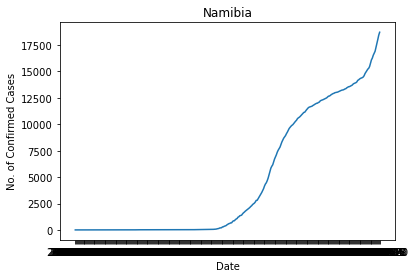

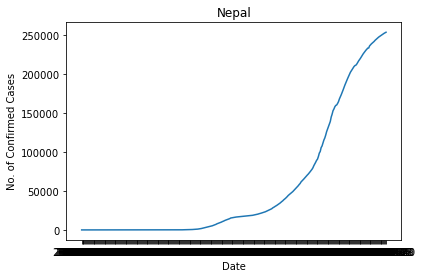

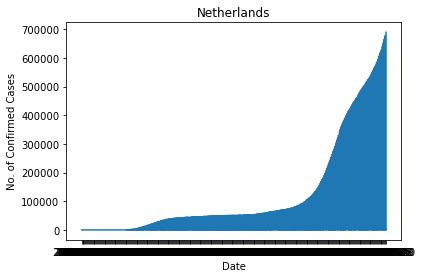

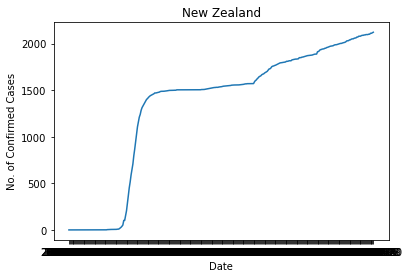

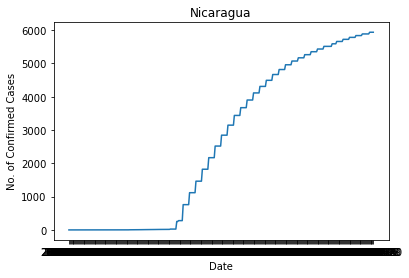

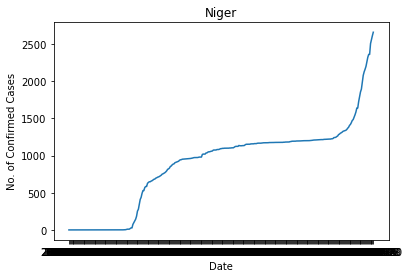

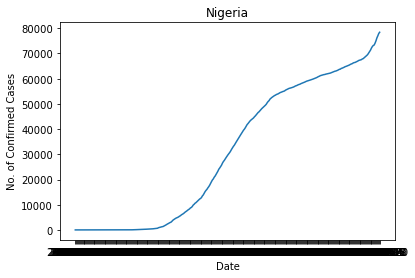

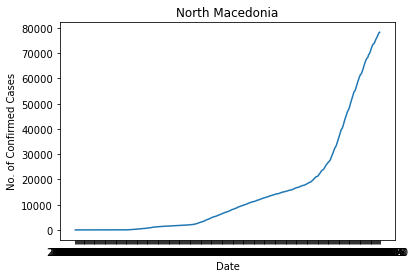

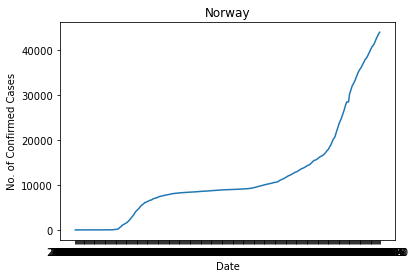

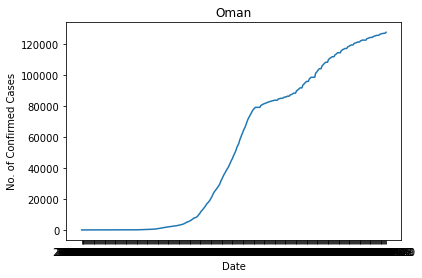

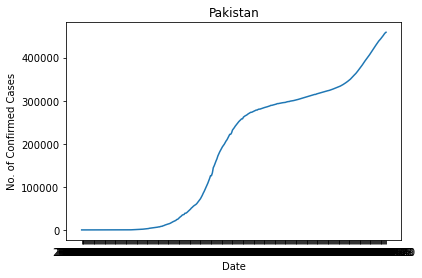

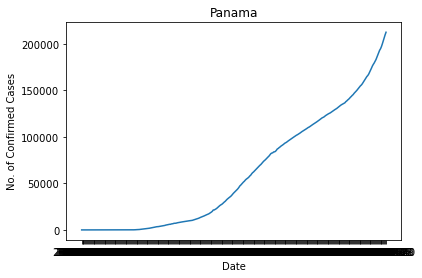

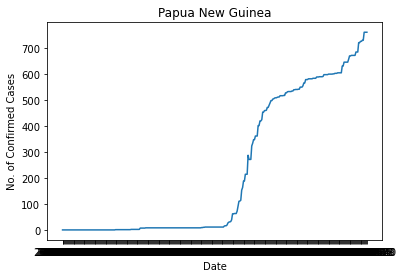

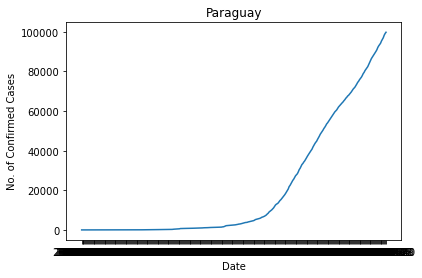

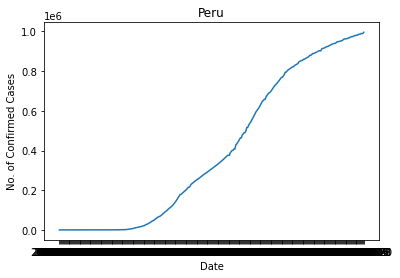

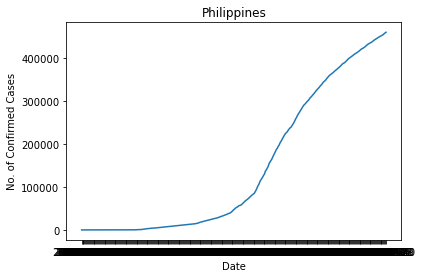

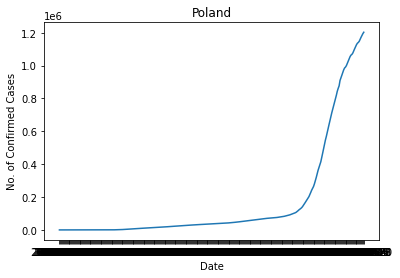

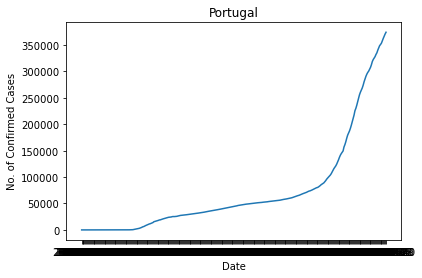

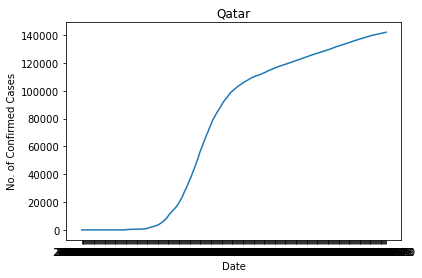

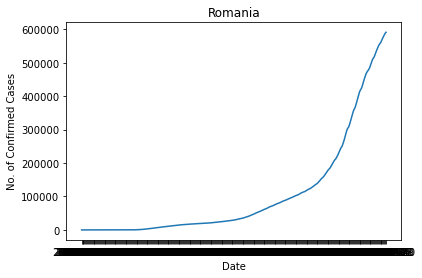

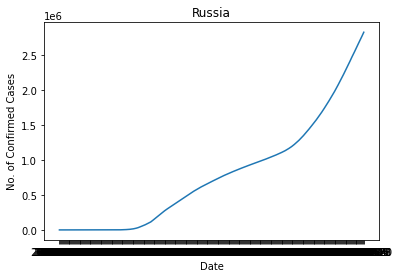

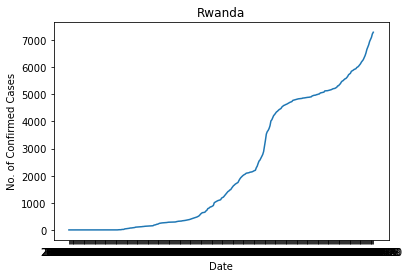

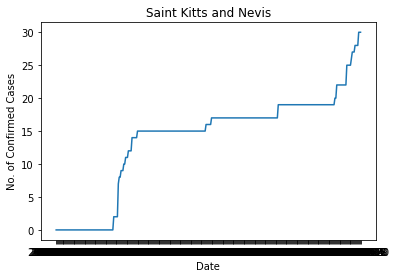

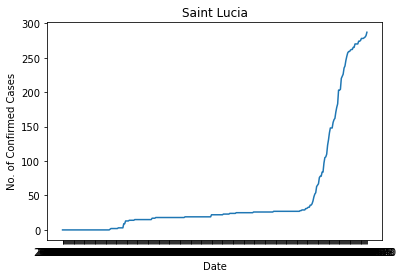

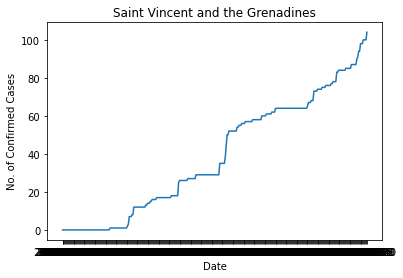

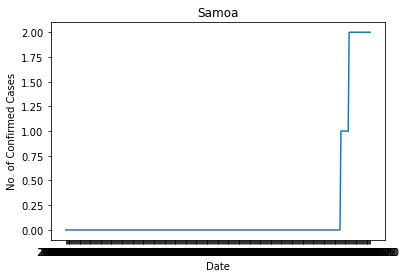

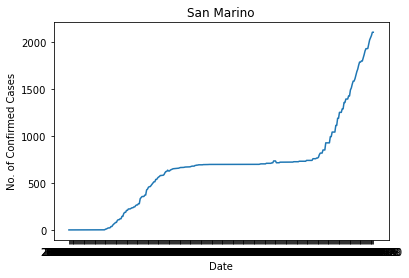

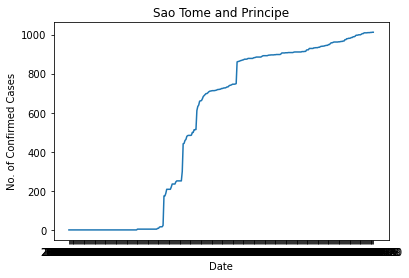

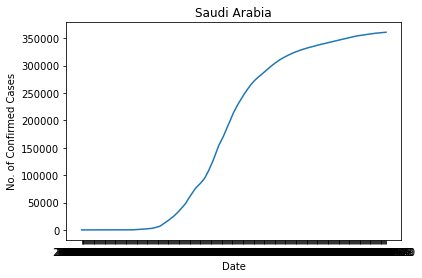

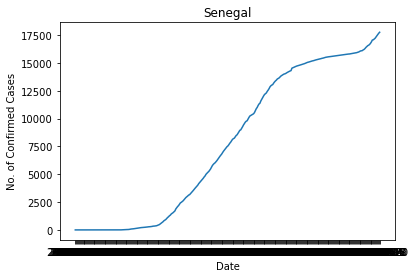

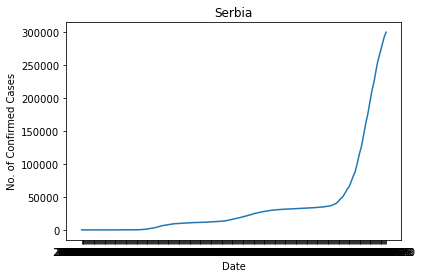

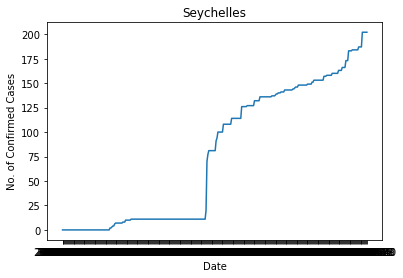

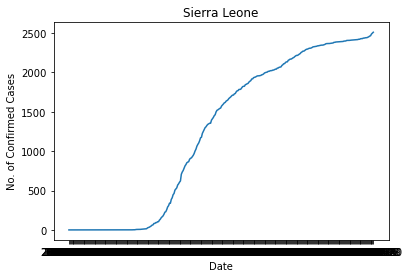

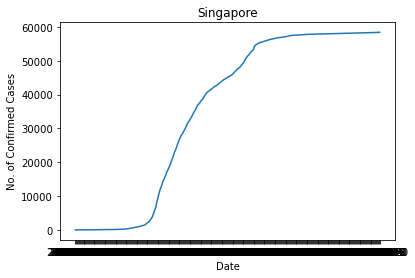

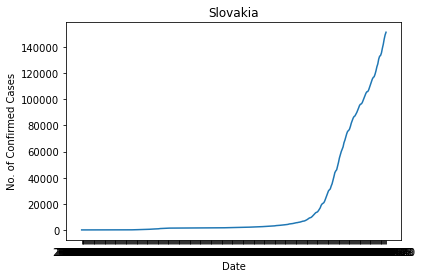

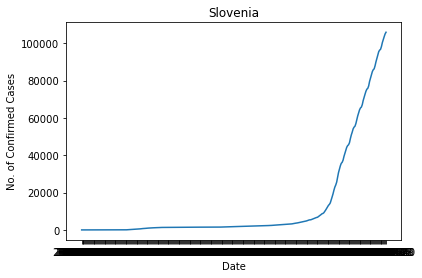

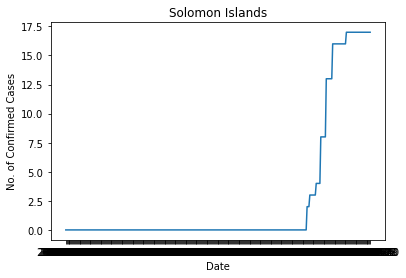

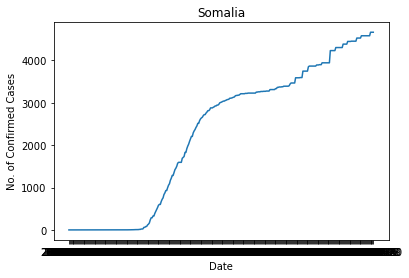

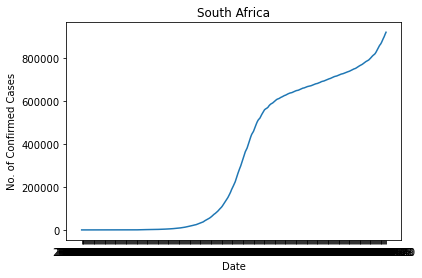

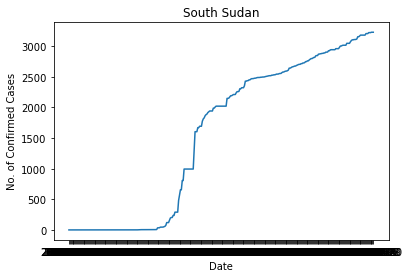

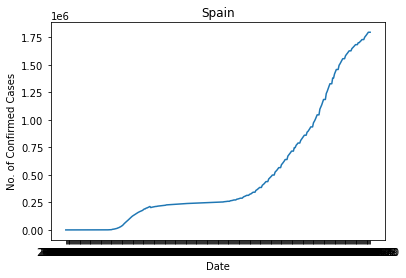

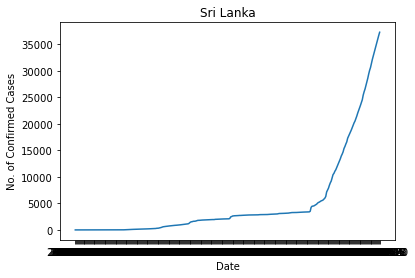

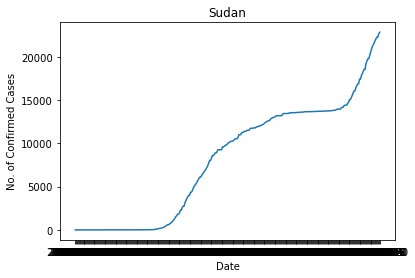

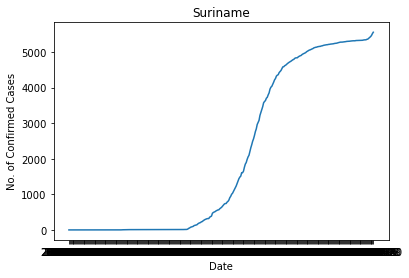

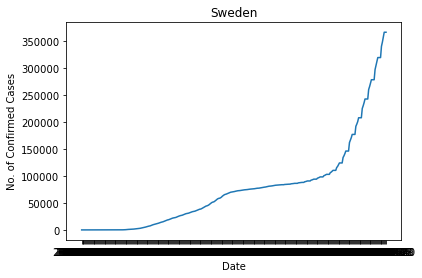

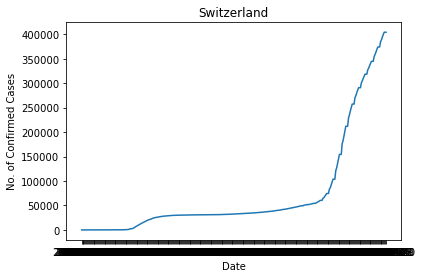

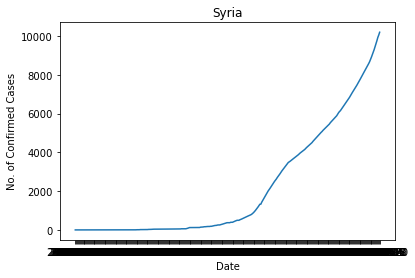

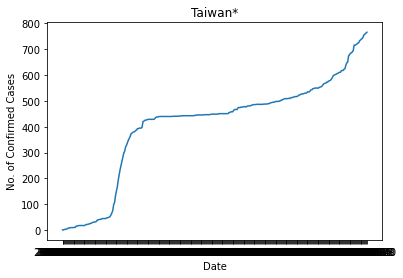

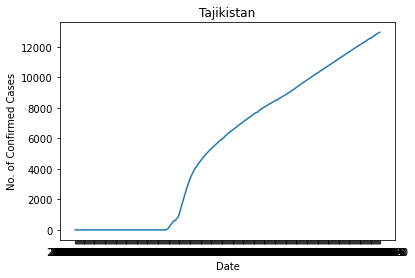

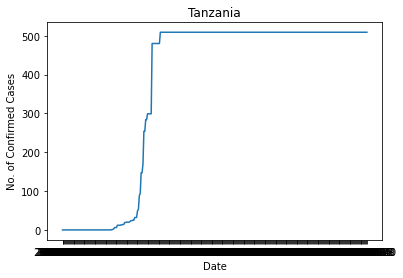

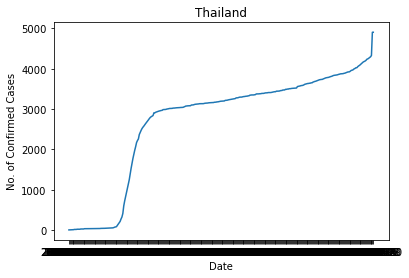

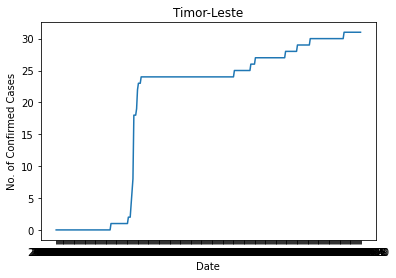

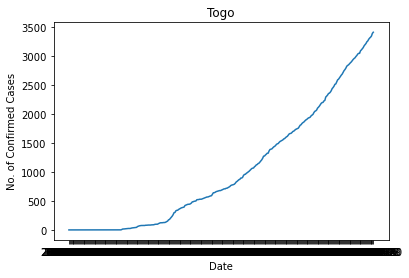

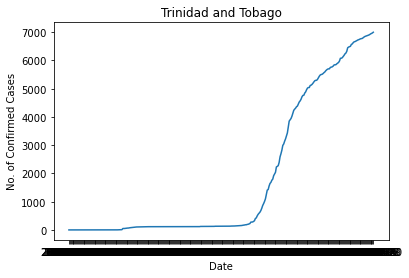

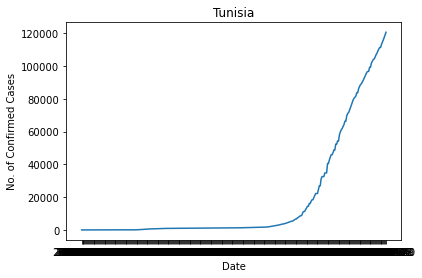

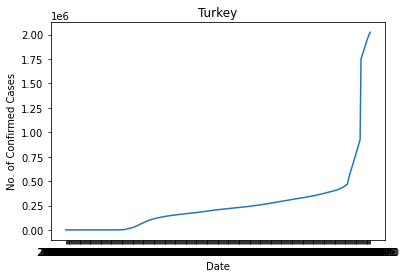

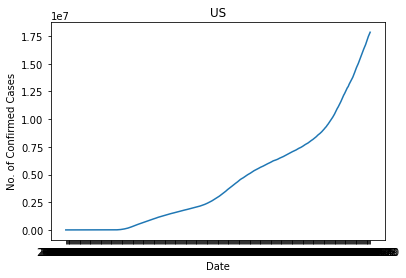

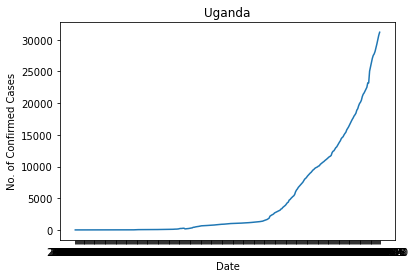

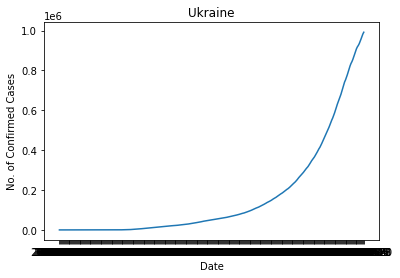

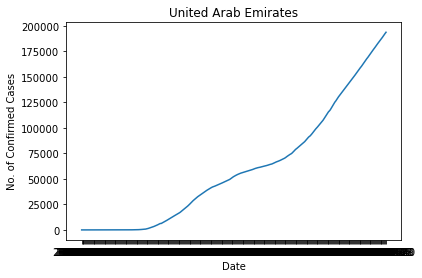

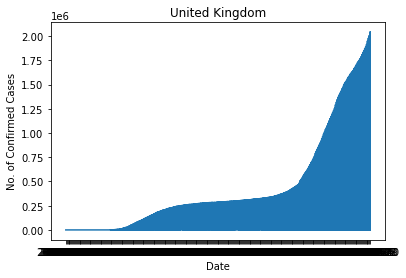

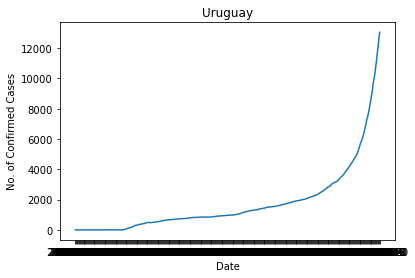

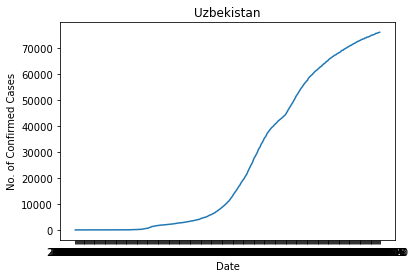

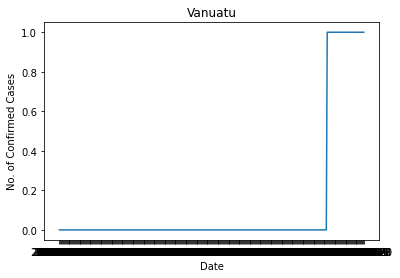

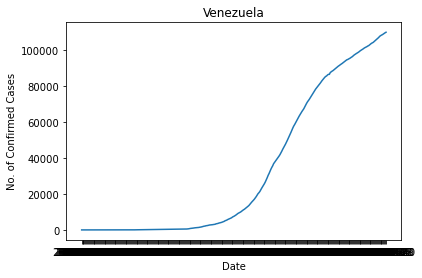

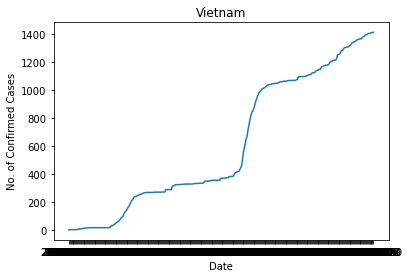

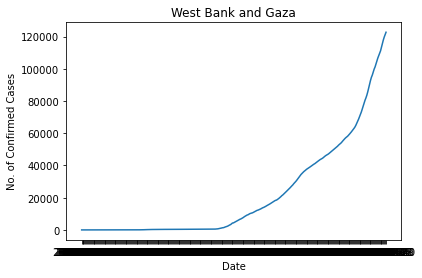

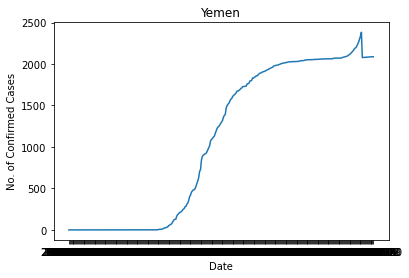

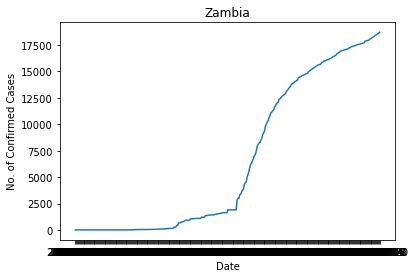

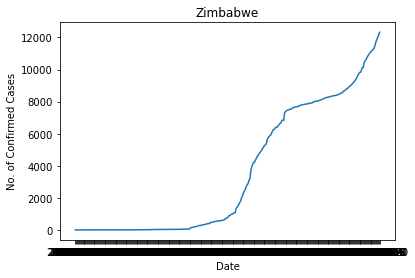



TOP 10 COUNTRIES WITH HIGHEST CONFIRMED CASES PER CAPITA

      country  ratio
0       Qatar  10.67
1     Andorra   8.69
2     Bahrain   8.40
3  San Marino   6.89
4    Holy See   5.16
5  Luxembourg   5.01
6      Panama   5.00
7       Chile   4.69
8      Kuwait   4.68
9      Israel   4.46


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import requests
import matplotlib.pyplot as plt

site = "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
r = requests.get(site)
url_content = r.content
csv_file = open('cdata.csv', 'wb')
csv_file.write(url_content)
csv_file.close()

df = pd.read_csv('cdata.csv')
df.drop('Province/State', axis=1)
df.head()

covid_data = {}
for country in df['Country/Region'].unique():
    new_df = df[(df['Country/Region'] == country)].copy()
    new_df.sort_values(by='Date', inplace=True, ascending=True)
    covid_data[country] = [new_df.loc[:, 'Date'].tolist(), new_df.loc[:, 'Confirmed'].tolist(),
                     new_df.loc[:, 'Recovered'].tolist(), new_df.loc[:, 'Deaths'].tolist()]

new_data = {'country':[], 'deaths': [], 'confirmed': []}
for var in covid_data:
    new_data['country'].append(var)
    new_data['deaths'].append(covid_data[var][3][-1])
    new_data['confirmed'].append(covid_data[var][1][-1])
recent_data = pd.DataFrame(new_data)

#Printing top 10 countries with highest values of confirmed cases

top_confirmed = recent_data.sort_values(by='confirmed', ascending=False)[:10]
top_confirmed = top_confirmed.loc[:, 'country'].tolist()
print("\n\nTOP 10 COUNTRIES WITH HIGHEST CONFIRMED CASES \n")
print(top_confirmed)

#Printing top 10 countries with highest values of deaths

top_deaths = recent_data.sort_values(by='deaths', ascending=False)[:10]
top_deaths = top_deaths.loc[:, 'country'].tolist()
print("\n\nTOP 10 COUNTRIES WITH HIGHEST DEATHS \n")
print(top_deaths)



for country in covid_data:
    plt.plot(covid_data[country][0], covid_data[country][1])
    plt.ylabel("No. of Confirmed Cases")
    plt.xlabel("Date")
    plt.title(country)
    plt.show()

    
cf_ratio = {'country': [], 'num': []}
for country in covid_data:
    cf_ratio['country'].append(country)
    val = sum(covid_data[country][1])/100
    if(val>0):
        val = sum(covid_data[country][3])/val
    else:
        val = sum(covid_data[country][3])/1
    cf_ratio['num'].append(round(val, 2))
        
dfa = pd.DataFrame(cf_ratio)
dfa = dfa.sort_values(by='num', ascending=False)[:20]
dfa = dfa.iloc[::-1]
fig = go.Figure(go.Bar(x=dfa.num, y=dfa.country, orientation='h'))
fig.update_layout(title="CASE FATALITY RATIO", xaxis_title="RATIO", yaxis_title="COUNTRIES",)
fig.show()

worldpop = pd.read_json('worldpopulation.json')
worldpop.set_index('country', inplace=True, drop=True)

#Removing unwanted columns from data file
worldpop.drop(['Rank', 'World'], axis=1, inplace=True)
temp = covid_data.copy()
popratio = {'country': [], 'ratio': []}
for country in temp:
    if(country in worldpop.index):
        covid_data[country].append(worldpop.loc[country].values[0])
        popratio['country'].append(country)
        popratio['ratio'].append(round(sum(covid_data[country][1])/worldpop.loc[country].values[0], 2))
    else:
        covid_data[country].append(np.NaN)
        
ratio_df = pd.DataFrame(popratio)
ratio_df.sort_values(by='ratio', ascending=False, inplace=True)
ratio_df.reset_index(inplace=True, drop=True)
print("\n\nTOP 10 COUNTRIES WITH HIGHEST CONFIRMED CASES PER CAPITA\n")
print(ratio_df.head(10))

climate = pd.read_json('climate.json')
climate_cntry = set(climate.country)
ratio_cntry =  set(ratio_df.country)
cntry = ratio_cntry & climate_cntry
climate_dict = dict.fromkeys(list(cntry)[:10], [0 for i in range(12)])
for i in range(len(climate)):
    row = climate.loc[i].values
    if row[2] in climate_dict.keys():
        for j in range(12):
            if climate_dict[row[2]][j] < row[-1][j]['high']:
                m = climate_dict[row[2]].copy()
                m[j] = row[-1][j]['high']
                climate_dict[row[2]] = m.copy()
        
from plotly.subplots import make_subplots

for country in df['Country/Region'].unique():
    if country in climate_dict.keys():
        new_df = df[(df['Country/Region'] == country)].copy()
        new_df['Date'] =  pd.to_datetime(new_df['Date'], infer_datetime_format=True)
        new_df = new_df.set_index("Date").copy()
        new_df = new_df.groupby(new_df.index.month).sum()
        
        fig = make_subplots(rows=1, cols=2, subplot_titles=('CONFIRMED CASES/MONTH', 'MONTHY HIGHEST AVG TEMP'))
        fig.add_trace(go.Scatter(x=new_df.index, y=new_df.Confirmed),row=1, col=1)
        fig.add_trace(go.Scatter(x=new_df.index, y=climate_dict[country]),row=1, col=2)

        fig.update_layout(height=400, width=1000, title_text=country, showlegend=False)
        fig.update_xaxes(title_text="Month", row=1, col=1)
        fig.update_xaxes(title_text="Month", row=1, col=2)
        fig.update_yaxes(title_text="No. of cases", row=1, col=1)
        fig.update_yaxes(title_text="Temperature", row=1, col=2)
        fig.show()

